In [27]:
import numpy as np
import scipy
import scipy.stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import cmdstanpy
from cmdstanpy import cmdstan_path, CmdStanModel, cmdstan_path, set_cmdstan_path
import os




In [67]:
import arviz as az

In [137]:
sns.set_theme(style="darkgrid")

In [35]:
set_cmdstan_path( os.path.join('/Users/javier/.cmdstan/cmdstan-2.27.0'))
cmdstan_path()

'/Users/javier/.cmdstan/cmdstan-2.27.0'

In [36]:
# Ver:
# https://arxiv.org/pdf/1903.00423v3.pdf Contemporary statistical inference for infectious disease models using Stan
# https://arxiv.org/pdf/2006.02985.pdf Bayesian workflow for disease transmission modeling in Stan
# MCMC HMC Hamiltonian Monte Carlo ---> STAN


#----- Problema Inverso: Dados los datos y_t del siguiente problema, como encuentro los parametros
# beta, gamma, S(0)?

#----- Ejemplo

# Problema: Influenza A H1N1  Escuela Britanica 1978 22 enero-04 de febrero
# Datos observados: Conteos diarios Y_t del numero de estudiantes infectados en un periodo de 14 dias
# N=763 estudiantes, 512 se enfermaron 

# Capitulo 9 De Vries et al. (2006) 
# Disponibles en RECON https://www.repidemicsconsortium.org 


# Verosimilitud: y_t ~ Poisson(I_t) 
# solamente se observan los infectados

# Prioris: 
#    beta ~ lognormal(0,1)
#    gamma ~ Gamma(0.02, 0.004 ) Tiempo medio de infeccion sea 5 dias
#    S(0)/N ~ beta( 0.5, 0.5 ) 



#datos, personas infectadas
yt=np.array(   [3,8,28,76,222,293, 257, 237, 192, 126, 70, 28, 12, 5]    )
t=np.arange(1,15,1)

Text(0.5, 1.0, 'Numero de ninos infectados UK 1978')

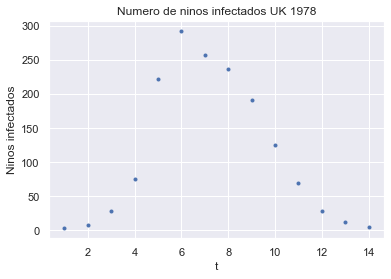

In [37]:
plt.plot(t,yt, '.')
plt.xlabel('t')
plt.ylabel('Ninos infectados')
plt.title('Numero de ninos infectados UK 1978')

In [38]:
#----- Ejemplo

# Problema: Influenza A H1N1  Escuela Britanica 1978 22 enero-04 de febrero
# Datos observados: Conteos diarios Y_t del numero de estudiantes infectados en un periodo de 14 dias
# N=763 estudiantes, 512 se enfermaron 

# Capitulo 9 De Vries et al. (2006) 
# Disponibles en RECON https://www.repidemicsconsortium.org 


# Verosimilitud: y_t ~ Poisson(I_t) 
# solamente se observan los infectados

# Prioris: 
#    beta ~ lognormal(0,1)
#    gamma ~ Gamma(0.02, 0.004 ) Tiempo medio de infeccion sea 5 dias
#    S(0)/N ~ beta( 0.5, 0.5 ) 



#datos, personas infectadas
yt=np.array(   [3,8,28,76,222,293, 257, 237, 192, 126, 70, 28, 12, 5]    )
t=np.arange(1,15,1)
N= 763
N_t= len(yt)

In [100]:
stan_data = {'t0': 0, 'N_t':N_t, 'ts':t, 'yt': yt, 'N':N}

In [99]:
sm = CmdStanModel(stan_file= 'EBSSIR.stan', cpp_options={"STAN_THREADS": True}); # compile model

INFO:cmdstanpy:compiling stan program, exe file: /Users/javier/EBSSIR
INFO:cmdstanpy:compiler options: stanc_options={}, cpp_options={'STAN_THREADS': True}
Warning in '/Users/javier/EBSSIR.stan', line 81, column 9: integrate_ode_rk45 is deprecated and will be removed in the future. Use ode_rk45 instead. 
The new interface is slightly different, see: 
https://mc-stan.org/users/documentation/case-studies/convert_odes.html
INFO:cmdstanpy:compiled model file: /Users/javier/EBSSIR


In [101]:
fit = sm.sample(data= stan_data, chains=4, output_dir= '.', iter_sampling=4000, seed=1,  ); # perform sampling


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3


In [102]:
print(fit)

CmdStanMCMC: model=EBSSIR chains=4['method=sample', 'num_samples=4000', 'algorithm=hmc', 'adapt', 'engaged=1']
 csv_files:
	/Users/javier/EBSSIR-202108202350-1.csv
	/Users/javier/EBSSIR-202108202350-2.csv
	/Users/javier/EBSSIR-202108202350-3.csv
	/Users/javier/EBSSIR-202108202350-4.csv
 output_files:
	/Users/javier/EBSSIR-202108202350-1-stdout.txt
	/Users/javier/EBSSIR-202108202350-2-stdout.txt
	/Users/javier/EBSSIR-202108202350-3-stdout.txt
	/Users/javier/EBSSIR-202108202350-4-stdout.txt


In [104]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,6500.00000,0.016000,1.20000,6500.00000,6500.00000,6500.0000,5800.0,110.0,1.0
beta,1.90000,0.000710,0.05300,1.80000,1.90000,2.0000,5600.0,110.0,1.0
gamma,0.48000,0.000130,0.01100,0.46000,0.48000,0.5000,7700.0,150.0,1.0
i0,0.00055,0.000002,0.00014,0.00035,0.00054,0.0008,5700.0,110.0,1.0
"Shat[1,1]",761.00000,0.005600,0.42000,760.00000,761.00000,762.0000,5773.0,109.0,1.0
...,...,...,...,...,...,...,...,...,...
Rrep[10],631.00000,0.071000,5.90000,621.00000,631.00000,641.0000,6916.0,131.0,1.0
Rrep[11],671.00000,0.060000,4.80000,663.00000,671.00000,679.0000,6537.0,124.0,1.0
Rrep[12],697.00000,0.050000,4.00000,690.00000,697.00000,703.0000,6303.0,119.0,1.0


In [105]:
fit.draws().shape

(4000, 4, 99)

In [161]:
theta=fit.draws_pd()

In [162]:
theta.columns

Index(['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__',
       'divergent__', 'energy__', 'beta', 'gamma', 'i0', 'Shat[1,1]',
       'Shat[2,1]', 'Shat[3,1]', 'Shat[4,1]', 'Shat[5,1]', 'Shat[6,1]',
       'Shat[7,1]', 'Shat[8,1]', 'Shat[9,1]', 'Shat[10,1]', 'Shat[11,1]',
       'Shat[12,1]', 'Shat[13,1]', 'Shat[14,1]', 'Shat[1,2]', 'Shat[2,2]',
       'Shat[3,2]', 'Shat[4,2]', 'Shat[5,2]', 'Shat[6,2]', 'Shat[7,2]',
       'Shat[8,2]', 'Shat[9,2]', 'Shat[10,2]', 'Shat[11,2]', 'Shat[12,2]',
       'Shat[13,2]', 'Shat[14,2]', 'Shat[1,3]', 'Shat[2,3]', 'Shat[3,3]',
       'Shat[4,3]', 'Shat[5,3]', 'Shat[6,3]', 'Shat[7,3]', 'Shat[8,3]',
       'Shat[9,3]', 'Shat[10,3]', 'Shat[11,3]', 'Shat[12,3]', 'Shat[13,3]',
       'Shat[14,3]', 'theta[1]', 'theta[2]', 'x0[1]', 'x0[2]', 'x0[3]',
       'Srep[1]', 'Srep[2]', 'Srep[3]', 'Srep[4]', 'Srep[5]', 'Srep[6]',
       'Srep[7]', 'Srep[8]', 'Srep[9]', 'Srep[10]', 'Srep[11]', 'Srep[12]',
       'Srep[13]', 'Srep[14]', 'Irep[1]', 

In [163]:
Srep=theta.loc[:, 'Srep[1]':'Srep[14]']
Irep=theta.loc[:, 'Irep[1]':'Irep[14]']
Rrep=theta.loc[:, 'Rrep[1]':'Rrep[14]']

Text(0.5, 1.0, 'S(t)')

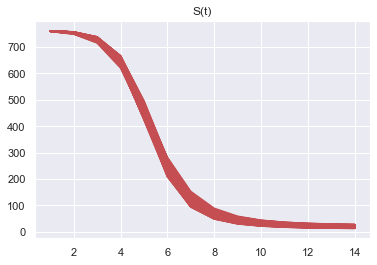

In [151]:
for i in range(0,500):
    plt.plot(t,pd.DataFrame.to_numpy(Srep.sample(1)).transpose(), 'r')
plt.title('S(t)')

Text(0.5, 1.0, 'I(t)')

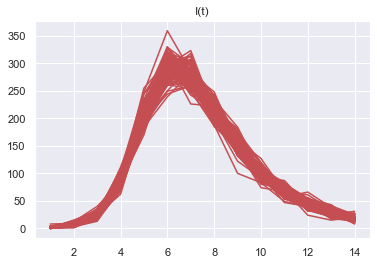

In [145]:
for i in range(0,100):
    plt.plot(t,pd.DataFrame.to_numpy(Irep.sample(1)).transpose(), 'r')
plt.title('I(t)')

Text(0.5, 1.0, 'R(t)')

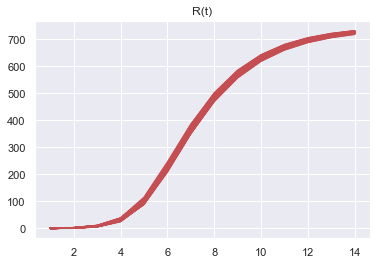

In [146]:
for i in range(0,100):
    plt.plot(t,pd.DataFrame.to_numpy(Rrep.sample(1)).transpose(), 'r')
plt.title('R(t)')

In [148]:
beta=theta.loc[:,'beta']
gamma= theta.loc[:,'gamma'], 
i0= theta.loc[:,'i0']

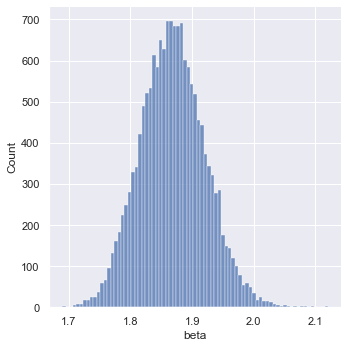

In [110]:
sns.displot(beta)

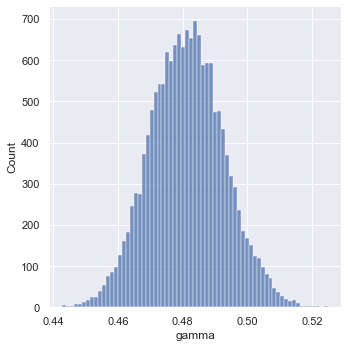

In [111]:
sns.displot(gamma)

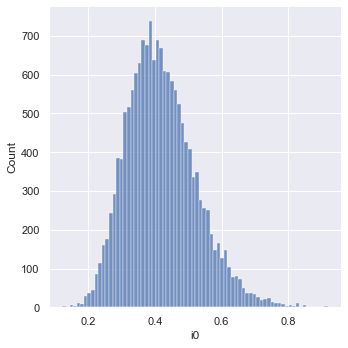

In [150]:
sns.displot(i0*N)

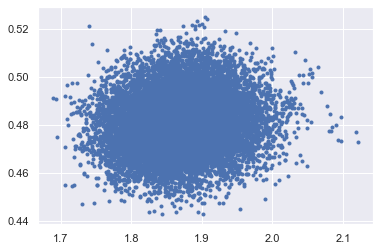

In [112]:
plt.plot(beta, gamma, '.')

In [165]:
results=theta.loc[:,['beta', 'gamma', 'i0']]
results['r0']= theta['beta']/ theta['gamma']


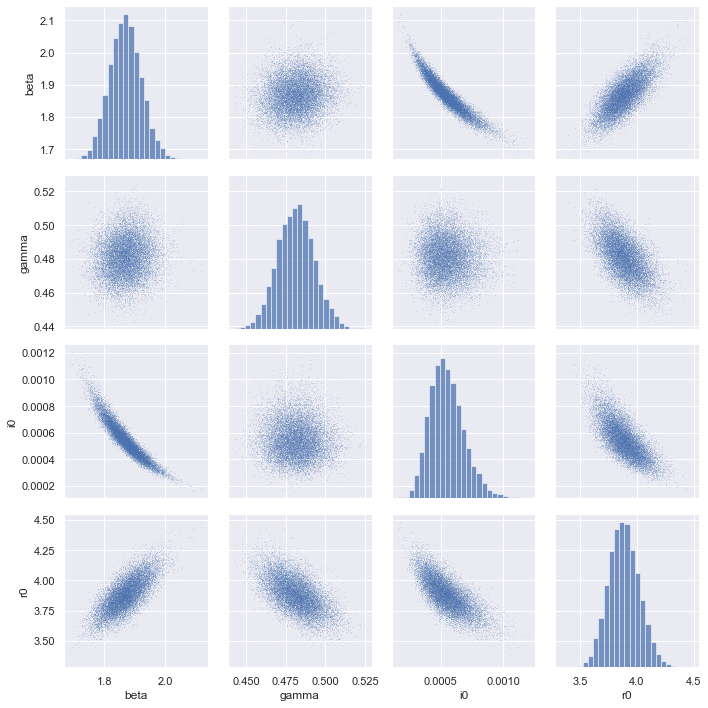

In [166]:
sns.pairplot(results, markers='.', plot_kws=dict(s=0.5, edgecolor="b"),diag_kws=dict(bins=25) )
plt.tight_layout()
